# CNN Model - Previous Fire Data and Weather

This notebook takes data from S3, trains a CNN model using Keras and Tensorflow, and saves the model to S3.

In [1]:
# Load packages
import boto3
import csv
import io
import json
import math
import numpy as np
import os
import pandas as pd
import pickle
import random

from datetime import datetime as dt
from keras.models import model_from_json
from matplotlib import pyplot as plt
from PIL import Image

Using TensorFlow backend.


### Variables and Hyperparameters

In [2]:
# s3 config
s3_client = boto3.client('s3')
bucket_name = 'hotzone'

# CNN config

# the desired height and width (in pixels) of the matrix to feed into the CNN
# 1 pixel side = 500 meters = 0.310686 miles
matrix_dim = 32

# test size for train/test split
test_size = 0.2

# training epochs
epoc = 10

## Pull Data from S3

In [3]:
def pull_data_from_s3(s3_client, bucket_name, key_name):
    '''
    Pulls pre-processed data from S3.

    Args:
        - s3_client: boto3 s3 client
        - bucket_name: name of bucket on s3 to pull data from
        - key_name: directory/file_name to pull data from
    Returns:
        - Nothing
    
    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''
    
    array_data = io.BytesIO()
    s3_client.download_fileobj(bucket_name, key_name, array_data)
    
    array_data.seek(0)
    array = pickle.load(array_data)

    return array

In [4]:
years = [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

fire = []
weather = []
Y = []

for y in years:
    print('*****************************************')
    print('Starting data preprocessing for year: ', y)
    time = dt.now()
    print (time)
    print('*****************************************')
    
    fire_key_name = "input_fire/fire_{}.pickle".format(str(y))
    weather_key_name = "input_weather/weather_{}.pickle".format(str(y))
    label_key_name = "labels/label_{}.pickle".format(str(y))
    
    fire_data = pull_data_from_s3(s3_client, bucket_name, fire_key_name)
    weather_data = pull_data_from_s3(s3_client, bucket_name, weather_key_name)
    labels = pull_data_from_s3(s3_client, bucket_name, label_key_name)
    
    fire.append(fire_data)
    weather.append(weather_data)
    Y.append(labels)

*****************************************
Starting data preprocessing for year:  2003
2020-04-18 19:40:19.023718
*****************************************
*****************************************
Starting data preprocessing for year:  2004
2020-04-18 19:40:19.726216
*****************************************
*****************************************
Starting data preprocessing for year:  2005
2020-04-18 19:40:20.434671
*****************************************
*****************************************
Starting data preprocessing for year:  2006
2020-04-18 19:40:20.823046
*****************************************
*****************************************
Starting data preprocessing for year:  2007
2020-04-18 19:40:21.448513
*****************************************
*****************************************
Starting data preprocessing for year:  2008
2020-04-18 19:40:22.092139
*****************************************
*****************************************
Starting data preprocessing 

In [5]:
fire = np.concatenate(fire)
weather = np.concatenate(weather)
Y = np.concatenate(Y)

print(fire.shape)
print(weather.shape)
print(Y.shape)

(131300, 32, 32, 1)
(131300, 6)
(131300,)


## Build CNN

In [6]:
# import packages

from __future__ import print_function

import tensorflow as tf

import keras
import keras.backend as K

from keras.models import Sequential, Model
from keras.layers import AveragePooling2D, Conv1D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, concatenate, LSTM

In [7]:
# compute f1 score manually - taken from https://datascience.stackexchange.com/a/45166

def recall_m(y_true, y_pred):
    '''
    Computes recall.
    
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - recall: true positives / actual results
    '''
    
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_pos / (possible_pos + K.epsilon())

    return recall


def precision_m(y_true, y_pred):
    '''
    Computes precision.
    
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - precision: true positives / predicted results
    '''
    
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_pos / (predicted_pos + K.epsilon())
    
    return precision


def f1_score(y_true, y_pred):
    '''
    Args:
        - y_true: true values of target variable.
        - y_pred: predicted values of target variable.
    Returns:
        - score: f1 score
    '''
    
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    score = 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return score

In [8]:
# # Create model_2: image data, weather data, and fire speed/direction data with functional API

# Define image inputs shape
image_shape = fire[0].shape
image_inputs = Input(shape = image_shape)

# Define weather inputs shape
weather_shape = weather[0].shape
weather_inputs = Input(shape = weather_shape)

# Add layers for fire image interpretation
fire_1 = AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid')(image_inputs)

fire_8 = Conv2D(16, kernel_size=(2, 2), activation='tanh')(fire_1)
fire_9 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(fire_8)
fire_10 = Dropout(0.2)(fire_9)

fire_11 = Conv2D(32, kernel_size=(2, 2), activation='tanh')(fire_10)
fire_12 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(fire_11)
fire_13 = Dropout(0.2)(fire_12)

fire_14 = Conv2D(64, kernel_size=(2, 2), activation='tanh')(fire_13)
fire_15 = MaxPooling2D(pool_size=(2,2), strides=None, padding='valid')(fire_14)
fire_16 = Dropout(0.2)(fire_15)

fire_20 = Flatten()(fire_16)
fire_21 = Dense(128, activation='tanh')(fire_20)

# Combine the layers
concat = concatenate([fire_21, weather_inputs])

# Final dense layer 
predictions = Dense(1, activation='sigmoid')(concat)

# Define the model
model_2 = Model(inputs=[image_inputs, weather_inputs], outputs=predictions)

In [9]:
%%time
# compile the model
model_2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', f1_score, recall_m, tf.keras.metrics.AUC()]
)

CPU times: user 184 ms, sys: 0 ns, total: 184 ms
Wall time: 181 ms


In [10]:
%%time
# fit the model
history = model_2.fit(
    x = [fire, weather], 
    y = Y,
    validation_split = test_size, 
    epochs=epoc
)

Train on 105040 samples, validate on 26260 samples
Epoch 1/10
105040/105040 [==============================] - 102s 973us/step - loss: 0.0209 - accuracy: 0.9961 - f1_score: 0.9863 - recall_m: 0.9816 - auc: 0.9925 - val_loss: 0.0246 - val_accuracy: 0.9960 - val_f1_score: 0.9886 - val_recall_m: 0.9822 - val_auc: 0.9953
Epoch 2/10
105040/105040 [==============================] - 79s 750us/step - loss: 0.0144 - accuracy: 0.9976 - f1_score: 0.9938 - recall_m: 0.9920 - auc: 0.9958 - val_loss: 0.0249 - val_accuracy: 0.9962 - val_f1_score: 0.9890 - val_recall_m: 0.9841 - val_auc: 0.9955
Epoch 3/10
105040/105040 [==============================] - 129s 1ms/step - loss: 0.0140 - accuracy: 0.9977 - f1_score: 0.9929 - recall_m: 0.9918 - auc: 0.9958 - val_loss: 0.0239 - val_accuracy: 0.9961 - val_f1_score: 0.9889 - val_recall_m: 0.9850 - val_auc: 0.9956
Epoch 4/10
105040/105040 [==============================] - 82s 777us/step - loss: 0.0137 - accuracy: 0.9977 - f1_score: 0.9930 - recall_m: 0.9917 -

## Save CNN to S3

In [25]:
def save_array_to_s3(s3_client, array, bucket_name, key_name):
    '''
    Uploads pre-processed data to S3.

    Args:
        - s3_client: boto3 s3 client
        - array: numpy array to save to s3
        - bucket_name: name of bucket on s3 to save array to
        - key_name: directory/file_name to save data to
    Returns:
        - Nothing
    
    https://stackoverflow.com/questions/48049557/how-to-write-npy-file-to-s3-directly
    '''
    
    array_data = io.BytesIO()
    pickle.dump(array, array_data)
    array_data.seek(0)
    
    s3_client.upload_fileobj(array_data, bucket_name, key_name)

In [18]:
# get model config and model weights

config = model_2.get_config()
weights = model_2.get_weights()

In [35]:
# save model config and model weights to s3

save_array_to_s3(s3_client, config, bucket_name, 'models/model_config.pickle')
save_array_to_s3(s3_client, weights, bucket_name, 'models/model_weights.pickle')

## Load CNN from S3

In [19]:
new_config = pull_data_from_s3(s3_client, bucket_name, 'models/model_config.pickle')
new_weights = pull_data_from_s3(s3_client, bucket_name, 'models/model_weights.pickle')


new_model = keras.Model.from_config(new_config)
new_model.set_weights(new_wights)

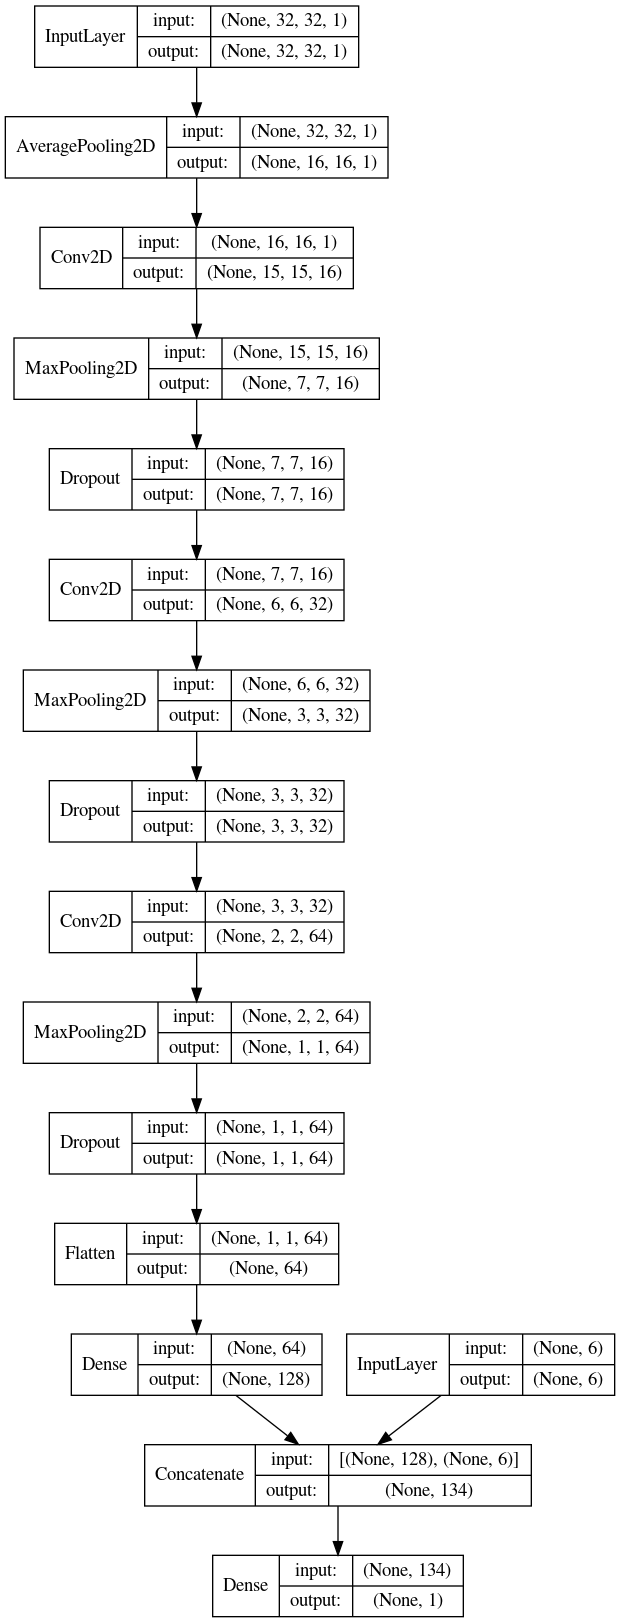

In [36]:
from keras.utils import plot_model
plot_model(
    new_model, 
    to_file='model.png', 
    rankdir='TB',
    show_layer_names=False,
    show_shapes=True,
    )

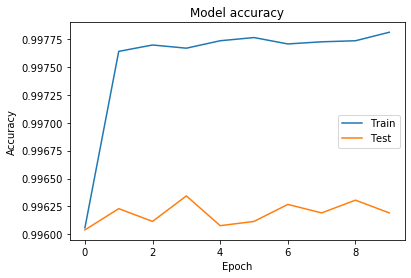

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

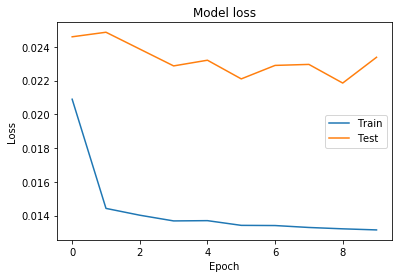

In [26]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

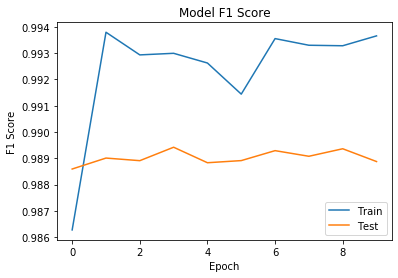

In [30]:
# Plot training & validation f1 score values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

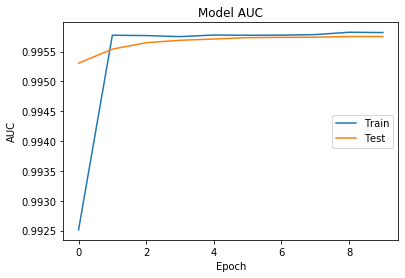

In [32]:
# Plot training & validation auc values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

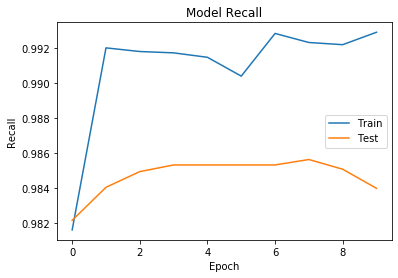

In [34]:
# Plot training & validation auc values
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()